# april 24, 2025: testing evidence values

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from statsmodels.stats.multitest import multipletests
from multiprocessing import Pool
import glob
import random
import re

from scipy.special import gammaln

import arviz as az

from itertools import product, combinations
import multiprocessing as mp
from functools import partial

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
from matplotlib.patches import Rectangle

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT
import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

def set_seed(args):
    gt.seed_rng(args.SEED)
    np.random.seed(args.SEED)

set_seed(args)

In [3]:
args.source = 'allen'
args.space = 'ccfv2'
args.brain_div = 'whl'
args.num_rois = 172
args.resolution = 200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [4]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'sub'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [5]:
main_folders = sorted(glob.glob(f'{SBM_path}/*', recursive=True))
main_folders

['/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/model-fits/sub-SLC01_task-rest',
 '/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/model-fits/sub-SLC03_task-rest',
 '/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/model-fits/sub-SLC04_task-rest',
 '/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/model-fits/sub-SLC05_task-rest',
 '/home/govindas/new_mouse_dataset/roi-results-v

In [6]:
sub_folder = main_folders[0]
len(sorted(glob.glob(f'{sub_folder}/sbm-*/B-*/desc-partitions.pkl')))

40

In [7]:
def get_identifiers(file):
    match = re.search(
            r'sub-([a-zA-Z0-9-]+).*sbm-([a-zA-Z0-9-]+).*B-(\d+)', 
            file
        )
    sub, sbm, B = match.group(1), match.group(2), match.group(3)
    return sub, sbm, B

In [8]:
def total_evidence(pmode, bs, dls):
    H = pmode.posterior_entropy()
    # logB = np.mean(gammaln(np.array([len(np.unique(b)) for b in bs]) + 1))
    L = -np.mean(dls) + H #+ logB
    return  -np.mean(dls), 0, H, L

def nested_total_evidence(pmode, bs, dls):
    H = pmode.posterior_entropy()
    # logB = np.mean([sum(gammaln(len(np.unique(bl))+1) for bl in b) for b in bs])
    L = -np.mean(dls) + H #+ logB
    return  -np.mean(dls), 0, H, L

In [9]:
if os.path.exists(f'pmode-dls-df.pkl'):
    with open(f'pmode-dls-df.pkl', 'rb') as f:
        [df] = pickle.load(f)
else:
    df = []
    for sub_folder in main_folders:
        pmode_files = sorted(glob.glob(f'{sub_folder}/sbm-*/B-*/desc-pmode.pkl'))
        partitions_files = sorted(glob.glob(f'{sub_folder}/sbm-*/B-*/desc-partitions.pkl'))
        for pm_file, b_file in tqdm(zip(pmode_files, partitions_files)):
            assert get_identifiers(pm_file) == get_identifiers(b_file)
            (sub, sbm, B) = get_identifiers(pm_file)

            with open(pm_file, 'rb') as f:
                [pmode] = pickle.load(f)

            with open(b_file, 'rb') as f:
                [bs, Bs, Bes, dls] = pickle.load(f)

            num_modes = len(pmode.get_modes())

            if not 'h' in sbm:
                mdl, logB, H, L = total_evidence(pmode, bs, dls)
            else:
                mdl, logB, H, L = nested_total_evidence(pmode, bs, dls)

            row = pd.DataFrame(dict(
                sub=[sub],
                sbm=[sbm],
                B=[B],
                mdl=[mdl],
                logB=[logB],
                H=[H],
                L=[L],
                num_modes=[num_modes],
            ))
            df += [row]

    df = pd.concat(df).reset_index(drop=True)   

In [10]:
with open(f'pmode-dls-df.pkl', 'wb') as f:
    pickle.dump([df], f)

<Axes: xlabel='H', ylabel='Density'>

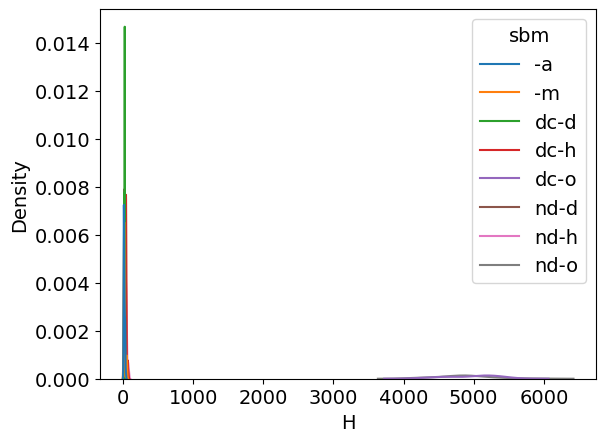

In [11]:
sns.kdeplot(df, x='H', hue='sbm')

In [12]:
df_no_o = df[~df['sbm'].isin(['nd-o', 'dc-o'])]

<Axes: xlabel='H', ylabel='Density'>

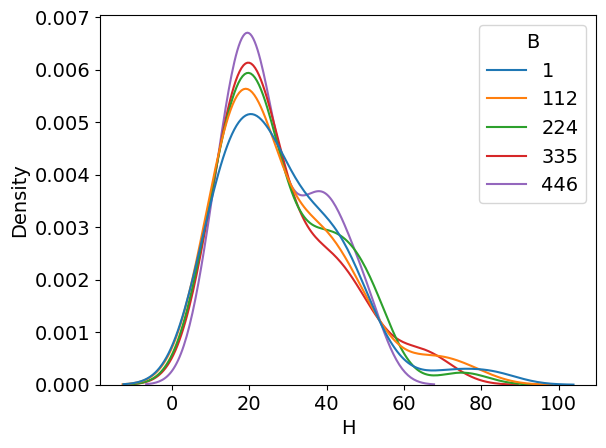

In [13]:
sns.kdeplot(df_no_o, x='H', hue='B')

<Axes: xlabel='H', ylabel='Density'>

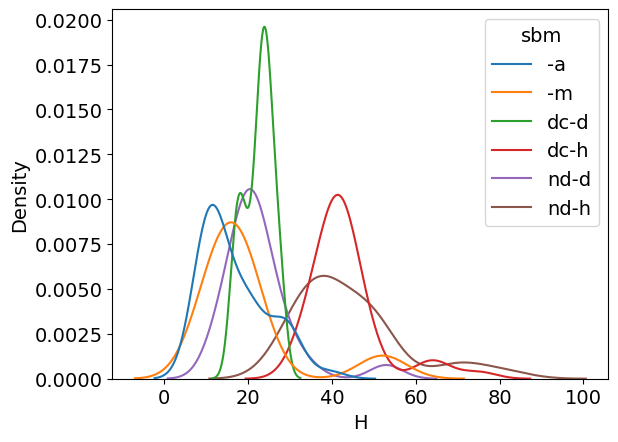

In [14]:
sns.kdeplot(df_no_o, x='H', hue='sbm')

In [15]:
df_o = df[df['sbm'].isin(['nd-o', 'dc-o'])]

<Axes: xlabel='H', ylabel='Density'>

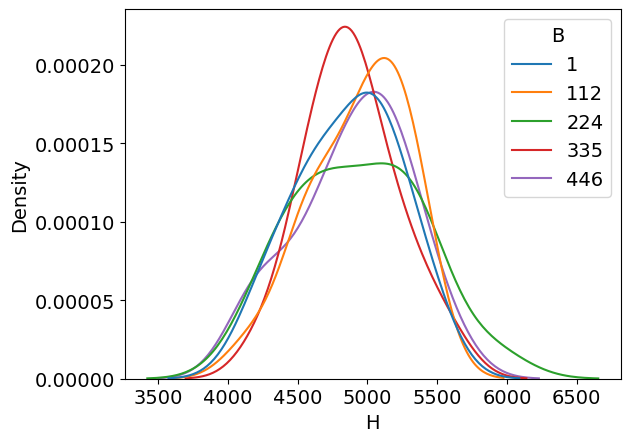

In [16]:
sns.kdeplot(df_o, x='H', hue='B')

<Axes: xlabel='H', ylabel='Density'>

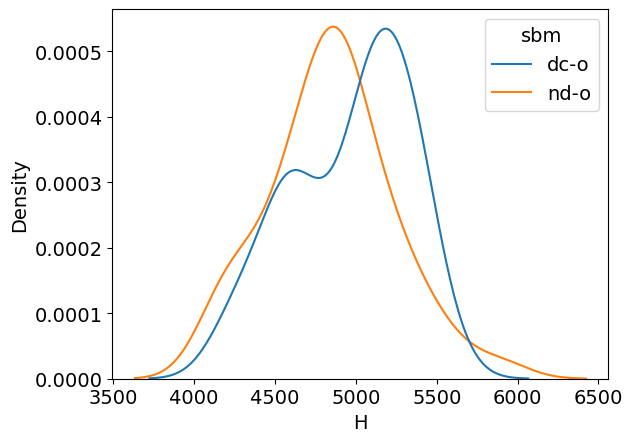

In [17]:
sns.kdeplot(df_o, x='H', hue='sbm')

---

In [18]:
def create_state(args, ):
    state_df = pd.DataFrame(columns=['a', 'd', 'o', 'h', 'm'],)
    state_df.loc['state'] = [
        gt.PPBlockState, gt.BlockState, 
        gt.OverlapBlockState, gt.NestedBlockState,
        gt.ModularityState,
    ]
    state_df.loc['state_args'] = [
        dict(), dict(deg_corr=args.dc, B=args.B), 
        dict(deg_corr=args.dc, B=args.B), dict(deg_corr=args.dc, B=args.B),
        dict(entropy_args=dict(gamma=args.gamma)),
    ]
    state, state_args = state_df[args.sbm]
    return state, state_args



In [25]:
args.dc = False
args.sbm = 'd'
args.B = 122
args.gamma = 2.0

In [26]:
gfile = sorted(glob.glob(f'{GRAPH_path}/*', recursive=True))[0]
g = gt.load_graph(gfile)
g

<Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7fa9bc206eb0>

In [27]:
if not args.sbm in ['h']:
    bs = []
    Bes = []
    dls = []
    for idx in tqdm(range(3000)):
        state, state_args = create_state(args)
        state = gt.minimize_blockmodel_dl(g, state=state, state_args=state_args)
        bs.append(state.b.a.copy())
        Bes.append(state.get_Be())
        dls.append(state.entropy())

100%|██████████| 3000/3000 [04:36<00:00, 10.86it/s]


In [28]:
if args.sbm in ['h']:
    bs = []
    Bes = [[] for s in range(9)]
    dls = []
    for idx in tqdm(range(3000)):
        state, state_args = create_state(args)
        state = gt.minimize_nested_blockmodel_dl(g, state=state, state_args=state_args)
        bs.append(state.get_bs())
        for l, sl in enumerate(state.get_levels()):
            Be = sl.get_Be()
            Bes[l].append(Be)
        dls.append(state.entropy())

In [29]:
def posterior_modes(args, bs):
    pmode = gt.ModeClusterState(bs, nested=args.nested)
    gt.mcmc_equilibrate(pmode, wait=1, mcmc_args=dict(niter=1, beta=np.inf))
    return pmode

In [30]:
args.nested=(args.sbm=='h')
pmode = posterior_modes(args, bs)

In [31]:
H = pmode.posterior_entropy()
if args.sbm in ['h']:
    logB = np.mean([sum(gammaln(len(np.unique(bl))+1) for bl in b) for b in bs])
else:
    logB = np.mean(gammaln(np.array([len(np.unique(b)) for b in bs]) + 1))
mdl = -np.mean(dls)
H, logB, mdl

(78.80386576491749, 43.207920349702086, -6099.845223807057)